In [1]:
# tylko nowe cechy
# liczba nowych cech to połowa oryginalnych cech
# sqrt(n) zaokrąglony w góre
# klasyfikatory - zafiksowac sensowne ustawienia
# wagi sumowane do 1
# lecim po wszystkich zbiorach czemu nie
# k-fold cross validation
from multi_imbalance.datasets import load_datasets
import experiment as ex
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from multi_imbalance.utils.metrics import gmean_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from utils import plot_embeddings
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

/home/dhorna/anaconda3/envs/mgr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
datasets = load_datasets()

### One hot encoding for categorical columns

In [3]:
pd.DataFrame(data=datasets['cmc']['data']).apply(pd.Series.nunique)

0    34
1     4
2     4
3    15
4     2
5     2
6     4
7     4
8     2
dtype: int64

In [4]:
k = 'cmc'    
df = pd.DataFrame(data=datasets[k]['data'])
cutoff = 10

encoded = pd.get_dummies(df, columns=[1,2,6,7], drop_first=True)
# result_df = pd.concat([df, encoded], axis=1)
datasets[k]['data'] = encoded.values

In [5]:
datasets = {'cmc':datasets['cmc']}

In [6]:
# for k in datasets:
#     print(k)
#     print(datasets[k]['data'][:3,:])
#     print([np.unique(datasets[k]['data'][:,i]).size for i in range(datasets[k]['data'].shape[1])], datasets[k]['data'].shape[0])

In [7]:
config = ex.config_calculation_strategy2(datasets)

In [8]:
#sane defaults

config['cmc'] = {'nn_config': {'units_1st_layer': 17,
  'units_2nd_layer': 24,
  'units_3rd_layer': 12,
  'units_latent_layer': 4},
 'weighted_triplet_loss': True,
 'lr': 0.00001,
 'batch_size': 32,
 'gamma': 0.95,
 'epochs': 100}

In [9]:
# config['cmc'] = {'nn_config': {'units_1st_layer': 17,
#   'units_2nd_layer': 24,
#   'units_3rd_layer': 12,
#   'units_latent_layer': 4},
#  'weighted_triplet_loss': True,
#  'lr': 0.01,
#  'batch_size': 32,
#  'gamma': 0.95,
#  'epochs': 100}

In [10]:
def instantiate_classifiers():
    classifiers = {
            "RF24": RandomForestClassifier(random_state=0, min_samples_leaf=2, min_samples_split=4, class_weight='balanced'),
            "DT": DecisionTreeClassifier(random_state=0, min_samples_split=4, min_samples_leaf=2, class_weight='balanced'),
        } 
    return classifiers

cmc


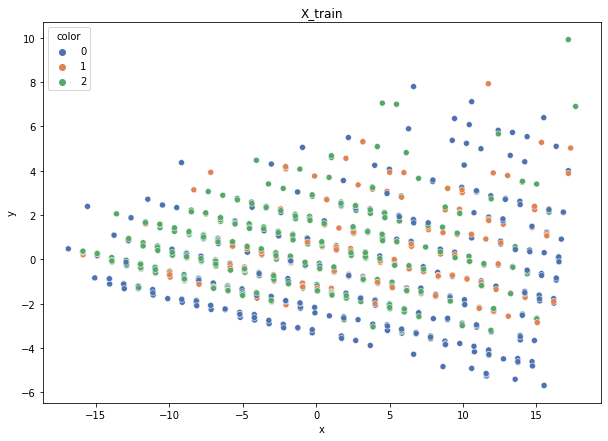

Class cardinalities: Counter({0: 503, 2: 409, 1: 266})
Weights: {0: 0.2426709552796112, 1: 0.45888530265279864, 2: 0.29844374206759033}


100%|██████████| 295/295 [00:00<00:00, 3265.97it/s]


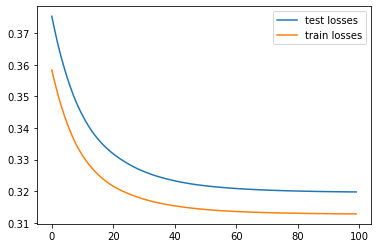

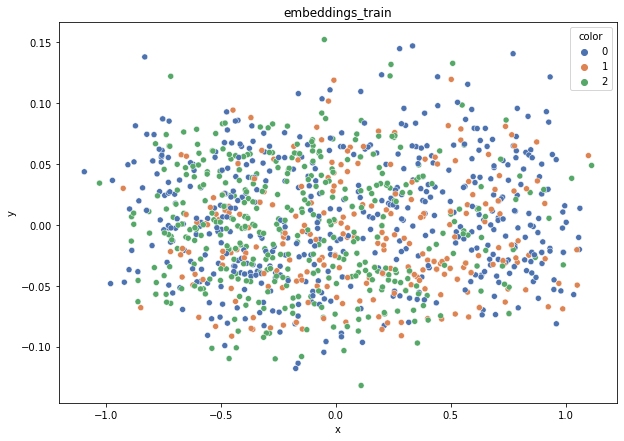

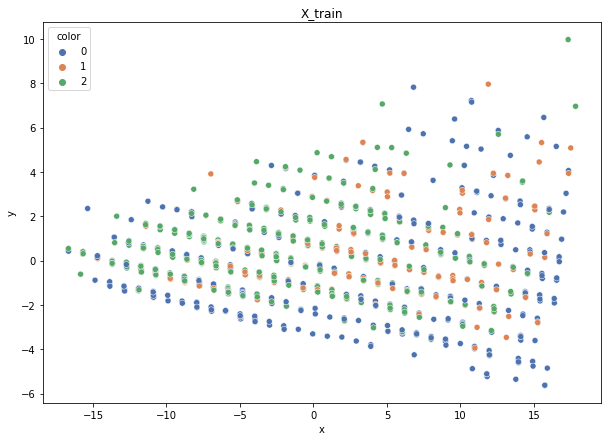

Class cardinalities: Counter({0: 503, 2: 409, 1: 266})
Weights: {0: 0.2426709552796112, 1: 0.45888530265279864, 2: 0.29844374206759033}


100%|██████████| 295/295 [00:00<00:00, 2520.78it/s]


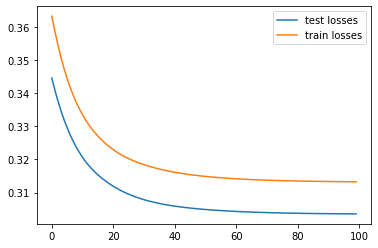

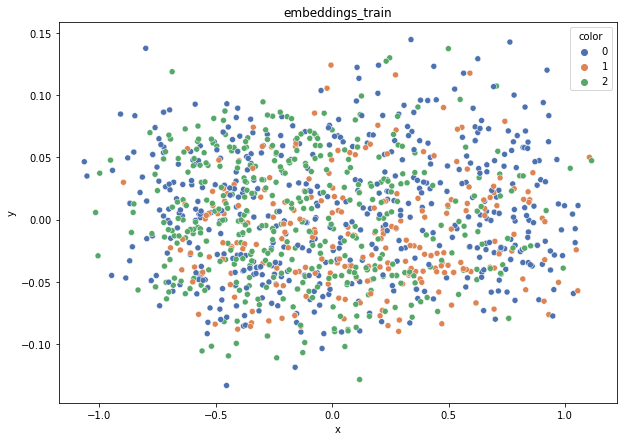

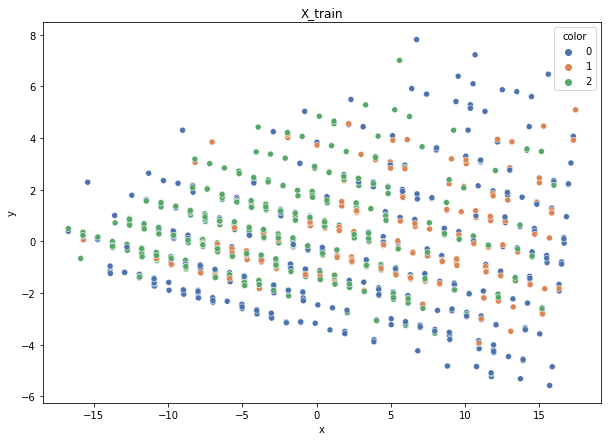

Class cardinalities: Counter({0: 503, 2: 408, 1: 267})
Weights: {0: 0.2429107547813522, 1: 0.45761838822104933, 2: 0.29947085699759846}


100%|██████████| 295/295 [00:00<00:00, 3269.09it/s]


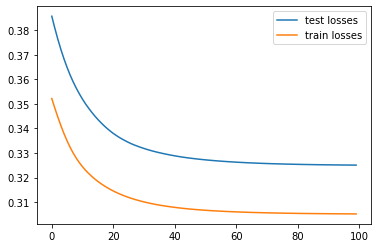

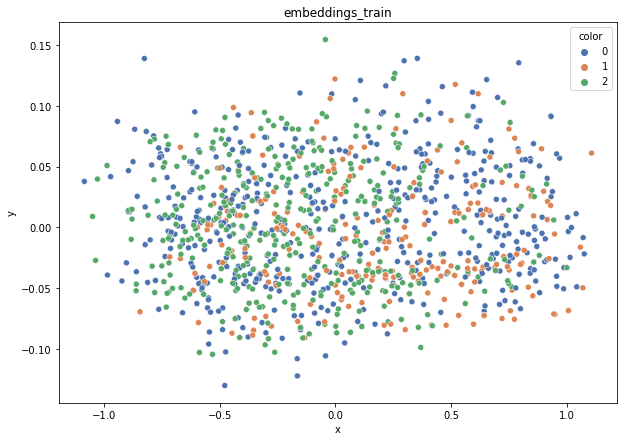

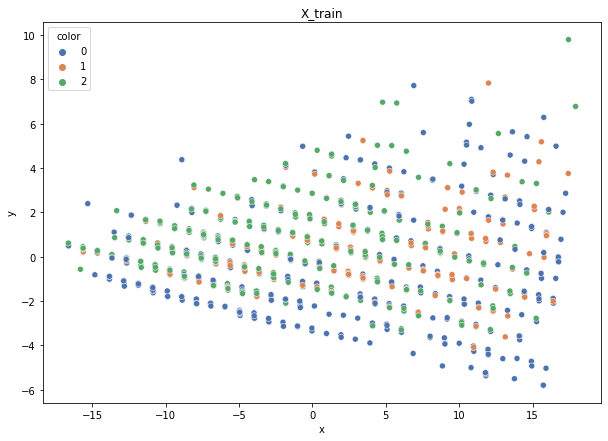

Class cardinalities: Counter({0: 503, 2: 409, 1: 267})
Weights: {0: 0.24308874498865835, 1: 0.4579537031059744, 2: 0.29895755190536716}


100%|██████████| 294/294 [00:00<00:00, 3039.66it/s]


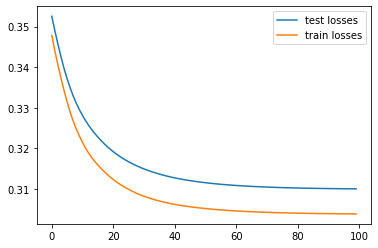

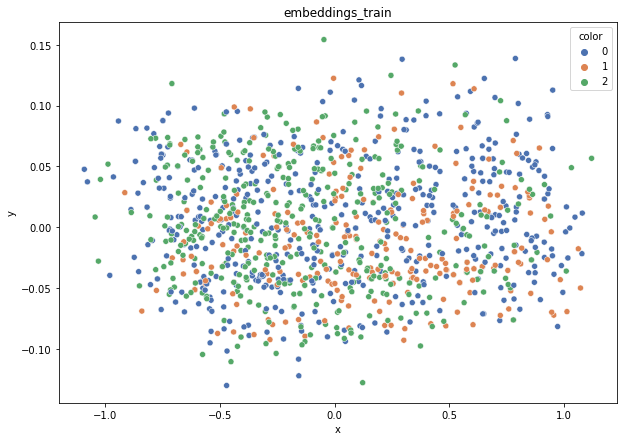

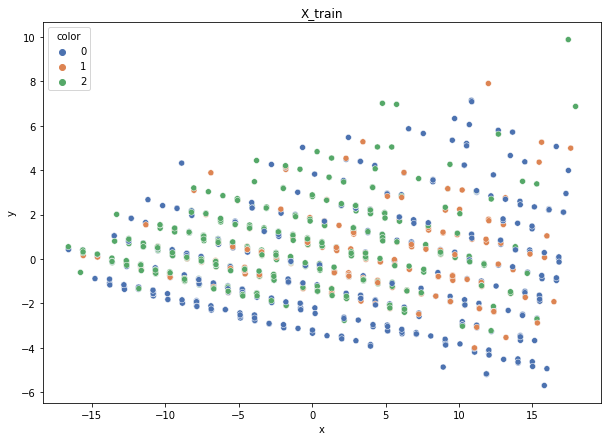

Class cardinalities: Counter({0: 504, 2: 409, 1: 266})
Weights: {0: 0.24230613326681422, 1: 0.4591063577687006, 2: 0.29858750896448505}


100%|██████████| 294/294 [00:00<00:00, 3316.99it/s]


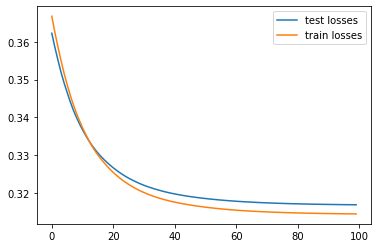

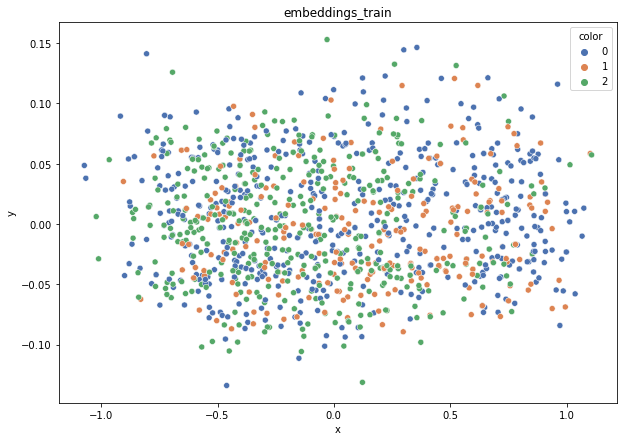

In [11]:
result_dict = defaultdict(list)

for dataset_name in ['cmc']:
# for dataset_name in list(datasets.keys()):
    print(dataset_name)
    result_dict["dataset"].append(dataset_name)
    X, y = datasets[dataset_name]['data'], datasets[dataset_name]['target']
    skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    n_splits = skf.get_n_splits(X, y)
    fold_result_dict = defaultdict(list)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # PCA X_train
        pca = PCA(n_components=2)
        plot_embeddings(pca.fit_transform(X_train), y_train)
        plt.title("X_train")
        plt.show()
        
        weights = ex.weights_calculation_strategy1(X_train, y_train)
        cfg =  config[dataset_name]
        # pretrain ANN triplets
        embeddings_train, embeddings_test = ex.train_triplets(X_train, y_train, X_test, y_test, weights,cfg)
        
        # PCA embeddings_train
        pca = PCA(n_components=2)
        plot_embeddings(pca.fit_transform(embeddings_train), y_train)
        plt.title("embeddings_train")
        plt.show()
        
        X_train_new = np.hstack([X_train, embeddings_train])
        X_test_new = np.hstack([X_test, embeddings_test])
        
        classifiers = instantiate_classifiers()
        for clf_name, clf in classifiers.items():
            clf.fit(X_train, y_train)
            preds = clf.predict(X_test)

            gmean = gmean_score(y_test, preds)
            f1 = f1_score(y_test, preds, average='macro')
            fold_result_dict[f"{clf_name}-f1-old-features"].append(f1)
            fold_result_dict[f"{clf_name}-gmean-old-features"].append(gmean)
            
        classifiers = instantiate_classifiers()
        for clf_name, clf in classifiers.items():
            clf.fit(X_train_new, y_train)
            preds = clf.predict(X_test_new)

            gmean = gmean_score(y_test, preds)
            f1 = f1_score(y_test, preds, average='macro')
            fold_result_dict[f"{clf_name}-f1-old+new-features"].append(f1)
            fold_result_dict[f"{clf_name}-gmean-old+new-features"].append(gmean)
            
        classifiers = instantiate_classifiers()
        for clf_name, clf in classifiers.items():
            clf.fit(embeddings_train, y_train)
            preds = clf.predict(embeddings_test)

            gmean = gmean_score(y_test, preds)
            f1 = f1_score(y_test, preds, average='macro')
            fold_result_dict[f"{clf_name}-f1-new-features"].append(f1)
            fold_result_dict[f"{clf_name}-gmean-new-features"].append(gmean)
    for k in fold_result_dict:
        result_dict[k].append(np.mean(fold_result_dict[k]))
        
            
            #f1, gmean
    # mean over folds
    # wiersze: datasety, 
    # kolumny -> klasyfikatory (przed dodaniem cech, po dodaniu, na samych nowych cechach)

In [12]:
results_df = pd.DataFrame.from_dict(result_dict)

In [13]:
results_df

,dataset,RF24-f1-old-features,RF24-gmean-old-features,DT-f1-old-features,DT-gmean-old-features,KNN-f1-old-features,KNN-gmean-old-features,RF24-f1-old+new-features,RF24-gmean-old+new-features,DT-f1-old+new-features,DT-gmean-old+new-features,KNN-f1-old+new-features,KNN-gmean-old+new-features,RF24-f1-new-features,RF24-gmean-new-features,DT-f1-new-features,DT-gmean-new-features,KNN-f1-new-features,KNN-gmean-new-features
0,cmc,0.522692,0.520398,0.466344,0.470049,0.432054,0.424198,0.51597,0.50375,0.45478,0.453874,0.432632,0.426323,0.408241,0.390696,0.387043,0.388385,0.3767,0.370421


In [14]:
results_df.filter(regex=("dataset|RF24-f1*"))

,dataset,RF24-f1-old-features,RF24-f1-old+new-features,RF24-f1-new-features
0,cmc,0.522692,0.51597,0.408241


In [15]:
results_df.filter(regex=("dataset|RF24-gmean*"))

,dataset,RF24-gmean-old-features,RF24-gmean-old+new-features,RF24-gmean-new-features
0,cmc,0.520398,0.50375,0.390696


In [16]:
results_df.filter(regex=("dataset|DT-f1*"))

,dataset,DT-f1-old-features,DT-f1-old+new-features,DT-f1-new-features
0,cmc,0.466344,0.45478,0.387043


In [17]:
results_df.filter(regex=("dataset|DT-gmean*"))

,dataset,DT-gmean-old-features,DT-gmean-old+new-features,DT-gmean-new-features
0,cmc,0.470049,0.453874,0.388385


In [18]:
results_df.filter(regex=("dataset|KNN-f1*"))

,dataset,KNN-f1-old-features,KNN-f1-old+new-features,KNN-f1-new-features
0,cmc,0.432054,0.432632,0.3767


In [19]:
results_df.filter(regex=("dataset|KNN-gmean*"))

,dataset,KNN-gmean-old-features,KNN-gmean-old+new-features,KNN-gmean-new-features
0,cmc,0.424198,0.426323,0.370421
